In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import Audio
import IPython.display as ipd
from scipy.io import wavfile
import tempfile
import os
import librosa
import pandas as pd
import seaborn as sns
import h5py
import mne
from scipy.stats import zscore
from mne_bids import BIDSPath, read_raw_bids
from matplotlib_venn import venn2,venn2_circles
from tqdm import tqdm

In [4]:
cm = 1/2.54
plt.rcParams['svg.fonttype'] = 'none'

fontdict = dict(fontsize=7)
fontsize = 7

red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

stg_color = '#20B2AA'
smc_color = '#6A5ACD'
insula_color = '#D4AF37'

reds = sns.light_palette(red, as_cmap=True)
blues = sns.light_palette(blue, as_cmap=True)
oranges = sns.light_palette(orange, as_cmap=True)
greens = sns.light_palette(green, as_cmap=True)

recon_dir = '/cwork/ns458/ECoG_Recon/'
mne.viz.set_3d_backend('notebook')                    # MNE 3D in-notebook static backend
# text svg

'notebook'

In [5]:
import pandas as pd
import numpy as np
from mne_bids import BIDSPath
from tqdm import tqdm

task = ['PhonemeSequence', 'LexicalDelay']

# task = ['LexicalDelay']

ref = 'bipolar'
time_paths = []
for t in task:
    time_paths.extend(
        BIDSPath(
            root=f'../results/{t}({ref})',
            datatype='HGA',
            suffix='time',  # 注意这里改成 'time'
            check=False,
        ).match()
    )

# 2. 筛选 perception 和 passive 的数据
time_dfs = []
for path in tqdm(time_paths):
    df = pd.read_csv(path)
    # 只保留 perception 或 passive
    time_dfs.append(df)

time_data = pd.concat(time_dfs)

# rename both phase : Resp and Response to Resp
time_data.loc[time_data.phase == 'Resp', 'phase'] = 'Response'
time_data.loc[time_data.phase == 'Response', 'phase'] = 'Response'

# rename phase of perception to audio
time_data.loc[time_data.description == 'passive', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'perception', 'phase'] = 'Audio'
time_data.loc[time_data.description == 'production', 'phase'] = 'Response'

# rename INS to 'Insula'
time_data.loc[time_data.roi == 'INS', 'roi'] = 'Insula'
# combine HG to STG
time_data.loc[time_data.roi == 'HG', 'roi'] = 'STG'
# rename CG to Cingulate cortex
time_data.loc[time_data.roi == 'PrG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'PoG', 'roi'] = 'SMC'
time_data.loc[time_data.roi == 'Subcentral', 'roi'] = 'SMC'

time_data = time_data[time_data.roi=='Insula']
time_data.head()

100%|██████████| 500/500 [00:10<00:00, 48.97it/s]


,time,channel,value,mask,roi,hemi,subject,description,task,phase,label,x,y,z
0,-1.000000,D0022_LPIF3-4,0.075033,False,Insula,L,D0022,production,PhonemeSequence,Response,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
2,-0.992188,D0022_LPIF3-4,0.103754,False,Insula,L,D0022,production,PhonemeSequence,Response,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
4,-0.984375,D0022_LPIF3-4,0.128319,False,Insula,L,D0022,production,PhonemeSequence,Response,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
6,-0.976562,D0022_LPIF3-4,0.126154,False,Insula,L,D0022,production,PhonemeSequence,Response,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079
8,-0.968750,D0022_LPIF3-4,0.102751,False,Insula,L,D0022,production,PhonemeSequence,Response,ctx_lh_S_circular_insula_inf,-34.587586,-19.67704,-2.311079


In [6]:
# 按功能分类电极：perception, production, sensorimotor, monitoring
# perception: Audio后0-0.5s有显著响应 (phase='Audio', time在0到0.5)
# production: Response前0.5s有显著响应 (phase='Response', time在-0.5到0)

# 1. 找出每个channel在perception窗口内是否有显著响应
perception_mask = (
    (time_data.phase == 'Audio') & 
    (time_data.time >= 0) & 
    (time_data.time <= 0.6) & 
    (time_data['mask'] == True)
)
perception_channels = time_data.loc[perception_mask, 'channel'].unique()

# 2. 找出每个channel在production窗口内是否有显著响应
production_mask = (
    (time_data.phase == 'Response') & 
    (time_data.time >= -0.5) & 
    (time_data.time <= 0) & 
    (time_data['mask'] == True)
)
production_channels = time_data.loc[production_mask, 'channel'].unique()

# 3. 分类
perception_set = set(perception_channels)
production_set = set(production_channels)

sensorimotor_channels = perception_set & production_set
just_perception_channels = perception_set - production_set
just_production_channels = production_set - perception_set

# 4. 创建映射字典
def get_functional_label(ch):
    if ch in sensorimotor_channels:
        return 'sensorimotor'
    elif ch in just_perception_channels:
        return 'perception'
    elif ch in just_production_channels:
        return 'production'
    else:
        return 'monitoring'

# 5. 添加functional_label列
time_data['functional'] = time_data['channel'].apply(get_functional_label)

# 统计结果
print(f"Perception only: {len(just_perception_channels)}")
print(f"Production only: {len(just_production_channels)}")
print(f"Sensorimotor: {len(sensorimotor_channels)}")
print(f"Monitoring: {len(time_data.channel.unique()) - len(perception_set | production_set)}")
print()
print(time_data.groupby('functional')['channel'].nunique())

Perception only: 52
Production only: 59
Sensorimotor: 88
Monitoring: 30

functional
monitoring      30
perception      52
production      59
sensorimotor    88
Name: channel, dtype: int64


Reading labels from parcellation...


   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


2025-12-25 22:18:32.562 (  76.246s) [    7FD717224440]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 22:18:32.590 (  76.275s) [    7FD717224440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x213e7a90): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 22:18:32.656 (  76.341s) [    7FD717224440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x212c9ed0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D 

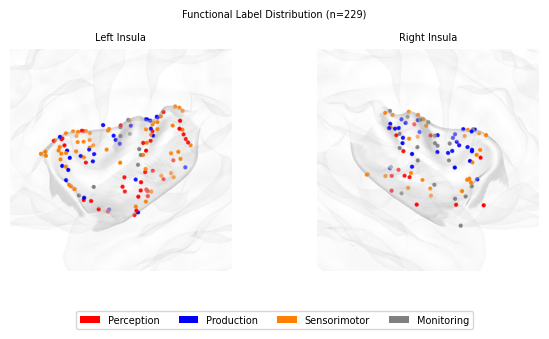

In [7]:
# 3D Insula Functional Label Visualization
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# 获取每个channel的functional label和坐标
# 先从time_data中获取每个channel的functional label和坐标
channel_info = time_data.drop_duplicates(subset=['channel'])[['channel', 'functional', 'x', 'y', 'z']].copy()

# 定义颜色映射
color_map = {
    'perception': (1.0, 0.0, 0.0),      # 红色
    'production': (0.0, 0.0, 1.0),      # 蓝色
    'sensorimotor': (1.0, 0.5, 0.0),    # 橙色
    'monitoring': (0.5, 0.5, 0.5)             # 灰色
}

# 电极坐标和颜色
coords = channel_info[['x', 'y', 'z']].values
labels_array = channel_info['functional'].values
colors = np.array([color_map[label] for label in labels_array])

mask_lh = coords[:, 0] < 0
mask_rh = coords[:, 0] > 0

# 电极大小
size = 15

def add_electrodes_with_labels(brain, coords, labels_array, tree, pial_coords, color_map, size):
    # 投影到表面
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        label = labels_array[i]
        color = color_map[label]
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_coords = coords[mask_lh]
    lh_labels = labels_array[mask_lh]
    add_electrodes_with_labels(lh_brain, lh_coords, lh_labels, lh_tree, lh_pial_coords, 
                               color_map, size)

# 添加右半球电极
if mask_rh.any():
    rh_coords = coords[mask_rh]
    rh_labels = labels_array[mask_rh]
    add_electrodes_with_labels(rh_brain, rh_coords, rh_labels, rh_tree, rh_pial_coords, 
                               color_map, size)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=180, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=180, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=(1.0, 0.0, 0.0), label='Perception'),
    Patch(facecolor=(0.0, 0.0, 1.0), label='Production'),
    Patch(facecolor=(1.0, 0.5, 0.0), label='Sensorimotor'),
    Patch(facecolor=(0.5, 0.5, 0.5), label='Monitoring')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=fontsize, bbox_to_anchor=(0.5, -0.05))

plt.suptitle("Functional Label Distribution (n={})".format(len(channel_info)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

In [8]:
speak_data = time_data[(time_data.phase == 'Response')&
                      #  (time_data.functional.isin(['perception','sensorimotor']))&
                      (time_data.functional.isin(['production','sensorimotor', 'monitoring']))&
                      (time_data.time <= 0) & 
                        (time_data.time >= -0.5)]
                       
speak_hga = speak_data.groupby('channel').agg({
    'value': 'mean',  
    'x': 'first',
    'y': 'first', 
    'z': 'first',
    'roi': 'first',
    'hemi': 'first',
    'subject': 'first',
    'description': 'first',
    'task': 'first'
}).reset_index()

speak_hga.head()

,channel,value,x,y,z,roi,hemi,subject,description,task
0,D0022_LPIF3-4,0.064627,-34.587586,-19.677040,-2.311079,Insula,L,D0022,production,PhonemeSequence
1,D0023_R2IF1-2,0.045320,33.089530,-8.192050,18.614382,Insula,R,D0023,Decision,LexicalDelay
2,D0023_R2IF2-3,-0.023613,36.686262,-8.172090,19.151989,Insula,R,D0023,Decision,LexicalDelay
3,D0027_LAI2-3,0.271932,-32.470676,9.175895,4.597974,Insula,L,D0027,Decision,LexicalDelay
4,D0027_LAI3-4,0.378274,-30.700923,13.124481,11.623351,Insula,L,D0027,Decision,LexicalDelay


Reading labels from parcellation...
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/lh.aparc.a2009s.annot
   read 75 labels from /cwork/ns458/ECoG_Recon/fsaverage/label/rh.aparc.a2009s.annot


VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 22:18:37.967 (  81.651s) [    7FD717224440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x325056b0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card0: Permission denied

2025-12-25 22:18:38.023 (  81.708s) [    7FD717224440] vtkEGLRenderWindow.cxx:353   WARN| vtkEGLRenderWindow (0x325056b0): EGL device index: 0 could not be initialized. Trying other devices...
VMware: No 3D enabled (0, Success).
libEGL warning: egl: failed to create dri2 screen
VMware: No 3D enabled (0, Success).
libEGL warning: 

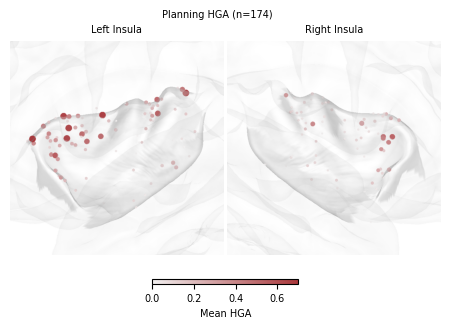

In [9]:
# 3D Insula HGA Visualization (color + size mapped to HGA)
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from mne.viz import Brain
from scipy.spatial import cKDTree
import matplotlib.colors as mcolors

# 读取aparc.a2009s labels
labels = mne.read_labels_from_annot(
    subject='fsaverage', parc='aparc.a2009s',  
    hemi='both', subjects_dir=recon_dir
)

# Insula相关的labels (aparc.a2009s)
insula_patterns = ['G_insular_short', 'G_Ins_lg_and_S_cent_ins', 
                   'S_circular_insula_ant', 'S_circular_insula_inf', 'S_circular_insula_sup']

# 加载pial表面用于投影
lh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/lh.pial")
rh_pial_coords, _ = mne.read_surface(f"{recon_dir}/fsaverage/surf/rh.pial")
lh_tree = cKDTree(lh_pial_coords)
rh_tree = cKDTree(rh_pial_coords)

# 计算insula区域的中心点
def get_insula_center(labels, hemi, pial_coords):
    vertices = []
    for lab in labels:
        if lab.hemi == hemi and any(p in lab.name for p in insula_patterns):
            vertices.extend(lab.vertices)
    if vertices:
        insula_coords = pial_coords[vertices]
        return insula_coords.mean(axis=0)
    return None

lh_insula_center = get_insula_center(labels, 'lh', lh_pial_coords)
rh_insula_center = get_insula_center(labels, 'rh', rh_pial_coords)

# 创建左右半球Brain对象
lh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="lh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)
rh_brain = Brain(
    "fsaverage", subjects_dir=recon_dir, surf="pial",
    hemi="rh", background="white", show=False,
    cortex=(0.9, 0.9, 0.9), alpha=0.05, size=(800, 800)
)

# 添加insula labels (高亮显示)
for lab in labels:
    if any(pattern in lab.name for pattern in insula_patterns):
        if lab.hemi == 'lh':
            lh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)
        elif lab.hemi == 'rh':
            rh_brain.add_label(lab, borders=False, color=(0.9, 0.9, 0.9), alpha=0.6)

# HGA数据 - 使用listen_hga
cord = speak_hga[['x', 'y', 'z']].values
hga_values = speak_hga['value'].values

mask_lh = cord[:, 0] < 0
mask_rh = cord[:, 0] > 0

# 设置 colormap 和归一化
cmap = reds
# cmap = blues
vmin, vmax = 0, np.percentile(hga_values, 95)
vmin, vmax = 0, 0.7
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# 点大小映射参数
size_min, size_max = 8, 25

def hga_to_size(hga, vmin, vmax, size_min, size_max):
    normalized = np.clip((hga - vmin) / (vmax - vmin), 0, 1)
    return size_min + normalized * (size_max - size_min)

def add_electrodes_with_hga(brain, coords, hga_vals, tree, pial_coords, cmap, norm, size_min, size_max):
    # 投影到表面
    _, indices = tree.query(coords)
    coords_proj = pial_coords[indices]
    
    for i in range(len(coords_proj)):
        pt = coords_proj[i:i+1]
        hga = hga_vals[i]
        color = cmap(norm(hga))[:3]
        size = hga_to_size(hga, vmin, vmax, size_min, size_max)
        
        cloud = pv.PolyData(pt)
        brain._renderer.plotter.add_mesh(
            cloud,
            render_points_as_spheres=True,
            point_size=size,
            color=color,
            lighting=False,
        )

# 添加左半球电极
if mask_lh.any():
    lh_cord = cord[mask_lh]
    lh_hga = hga_values[mask_lh]
    add_electrodes_with_hga(lh_brain, lh_cord, lh_hga, lh_tree, lh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 添加右半球电极
if mask_rh.any():
    rh_cord = cord[mask_rh]
    rh_hga = hga_values[mask_rh]
    add_electrodes_with_hga(rh_brain, rh_cord, rh_hga, rh_tree, rh_pial_coords, 
                            cmap, norm, size_min, size_max)

# 设置视角 - 聚焦在insula中心
lh_brain.show_view(azimuth=180, elevation=90, distance=160, focalpoint=lh_insula_center)
rh_brain.show_view(azimuth=0, elevation=90, distance=160, focalpoint=rh_insula_center)

# 截图并显示
fig, axes = plt.subplots(1, 2, figsize=(16*cm, 8*cm))

plt.subplots_adjust(wspace=-0.2)
axes[0].imshow(lh_brain.screenshot(mode="rgb"))
axes[0].axis("off")
axes[0].set_title("Left Insula", fontsize=fontsize)

axes[1].imshow(rh_brain.screenshot(mode="rgb"))
axes[1].axis("off")
axes[1].set_title("Right Insula", fontsize=fontsize)

# 添加colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1, aspect=30)
cbar.set_label('Mean HGA', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.suptitle("Planning HGA (n={})".format(len(speak_hga)), fontsize=fontsize)

lh_brain.close()
rh_brain.close()

plt.savefig("../img/fig1/fig1_local_insula_HGA_perception.svg", dpi=300)
plt.show()

In [15]:
# 找到HGA值最大的channel
max_hga_row = speak_hga.loc[speak_hga['value'].idxmax()]

print("HGA值最大的电极信息:")
print(f"Channel: {max_hga_row['channel']}")
print(f"HGA Value: {max_hga_row['value']:.4f}")
print(f"Subject: {max_hga_row['subject']}")
print(f"ROI: {max_hga_row['roi']}")
print(f"Hemisphere: {max_hga_row['hemi']}")
print(f"Coordinates: x={max_hga_row['x']:.2f}, y={max_hga_row['y']:.2f}, z={max_hga_row['z']:.2f}")

# 也可以看前10个最大的
print("\n前10个HGA值最大的电极:")
top_10 = speak_hga.nlargest(10, 'value')[['channel', 'value', 'subject', 'roi', 'hemi']]
print(top_10)

HGA值最大的电极信息:
Channel: D0103_LFAI2-3
HGA Value: 1.0942
Subject: D0103
ROI: Insula
Hemisphere: L
Coordinates: x=-34.18, y=26.42, z=1.61

前10个HGA值最大的电极:
           channel     value subject     roi hemi
170  D0103_LFAI2-3  1.094157   D0103  Insula    L
64   D0067_LPII1-2  0.943211   D0067  Insula    L
112   D0088_LAI5-6  0.715679   D0088  Insula    L
146  D0096_LFAI2-3  0.695217   D0096  Insula    L
91    D0080_LAI5-6  0.686152   D0080  Insula    L
113   D0088_LAI6-7  0.682369   D0088  Insula    L
12    D0035_LPI5-6  0.567441   D0035  Insula    L
133   D0094_LIA2-3  0.556791   D0094  Insula    L
81    D0079_LAI7-8  0.547390   D0079  Insula    L
31     D0047_LI5-6  0.533608   D0047  Insula    L
